# Restricted Boltzmann Machines

Baseado em: https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/


Boltzmann Machine pode ser considerada uma junção entre os campos de deep learning e fisica, e pode ser muito útil para redução de dimensionalidade, classificação, regressão, filtragem colaborativa, etc. 

## Trabalhando com Máquinas de Boltzmann

As máquinas de Boltzmann são inspiradas na distribuição de Boltzmann, a qual diz que o estado do sistema depende de sua energia e da temperatura em que esta operando, por isso, dizemos que o modelo e baseado em energia. O termo energia aqui é equivalente ao desvio da saida esperada. Quanto maior a energia, maior é o desvio. Sendo assim, o modelo é treinado com o objetivo de minimizar essa energia. 

<img src='assets/bm.png' width=800px>

## A intuição por trás das máquinas de Boltzmann

As máquinas de Boltzmann tem uma arquitetura diferente das demais redes neurais. Não existe uma demarcação clara entre camada de entrada e de saida. Na verdade, não tem camada de saida. Os nós em uma máquina de Boltzmann são categorizados apenas como visíveis ou escondidos. Os nós visíveis recebem os dados de entrada, e são reconstruidos como sendo os nós de saida. 

Na versão original da máquina de Boltzmann, todos os nós são conectados, sejam eles das camadas visivel ou invisivel, e todas as conexões são bi-direcionais.

<img src='assets/bmGraph.png' width=600px>

Além disso, cada nó pode assumir apenas dois estados possiveis, ligado ou desligado. O estado de um nó é determinado pelos pesos e bias associados a ele. 

## Tipos de máquinas de Boltzmann

Existem diversas variacões de Máquinas de Boltzmann que evoluiram com o tempo para resolver diversos tipos de problemas. Entre as mais conhecidas, podemos citar a Máquina de Boltzmann Restrita ( _Restricted Boltzmann Machine - RBM_ ), Máquina de Crenca Profunda ( _Deep Belief Network - DBN_ ) e a Máquina de Boltzmann Profunda ( _Deep Boltzmann Machine - DBM_ ). 

### Restricted Boltzmann Machines

O maior problema da maquina de Boltzmann convencional é a enorme quantidade de cálculos a serem executados mesmo para uma pequena quantidade de dados. Nesses casos, atualizar os pesos da rede se torna uma tarefa muito demorada devido as dependencias entre os nós. Para reduzir essa dependencia, uma restrição foi imposta ao modelo para remover as conexões intra-camadas. 

<img src='assets/bm_rbm.png' width=600px>

Essa restrição imposta as conexões tornam as unidades de entrada e os nós esondidos independentes dentro de suas camadas. Sendo assim, os pesos podem ser atualizados em paralelo.

<img src='assets/rbmCon.png' width=600px>

### Deep Belief Network e Deep Boltzmann Machines

Deep Belief Network e Deep Boltzmann Machines são versões empilhadas da RBM, criando modelos em profundidade. DBNs são inicializadas aleatoriamente e utilizam cadeias de Markov para definir a ocorrência de possíveis eventos, que são ajustados durante o processo de treinamento. O processo e lento, e as DBMs tentam oferecer uma solução mais prática com um treinamento mais refinado.

<img src='assets/dbn_dbm.png' width=600px>

Apesar das duas arquiteturas serem confundidas frequentemente, a diferença pode ser notada nas conexões. As conexões da DBN nas camadas superiores tem uma única direção, enquanto nas DBMs são bi-direcionais.

## Implementando RBMs com PyTorch


Vamos implementar a RBM em PyTorch para reconstrução de digitos usando o dataset MNIST.

### Passo 1: Importando os pacotes necessários

Nesse passo, importamos todos os pacotes. Note que usaremos `torchvision.utils` para visualização dos resultados.

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

### Passo 2: Carregando o dataset MNIST

Esse passo carrega o conjunto de treinamento e teste do dataset MNIST usando a classe Dataloader do pacote `torch.utils.data`. Vamos utilizar um batch de tamanho 64 e aplicar as transformações necessárias.


In [2]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Passo 3: Definindo o modelo

Nesse passo, começaremos a construir nosso modelo. Vamos definir as transformações associadas com os neurônios visiveis e escondidos. Além disso, pela RBM ser um modelo baseado em energia, vamos também definir uma função para computar a diferença de energia. Na inicialização da função, também inicializaremos os pesos e os bias para os neurônios visiveis e escondidos.

In [3]:
class RBM(nn.Module):
    def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()


Sempre precisamos definir o metodo forward, o qual e usado pela rede para propagar os pesos e os bias pela rede e computar todos os valores. O processo e repetido por $k$ vezes, o que define o numero de vezes em que computamos a divergencia constrastiva. Uma vez que as RBMs sao modelos baseados em energia, no fim definimos um metodo que calcula a energia do modelo.


### Passo 4: Inicializando e treinando o modelo

A classe da RBM que criamos e inicializada com $k=1$. Vamos usar o otimizador SGD no exemplo. No fim do processo, todas os custos sao acumulados em um vetor 1D. Extrairemos a distribuicao de Bernoulli usando o metodo `data.bernoulli()`. Esse e o padrao de entrada com o qual comecaremos.

Uma amostra de entrada e usada para alimentar a RBM, a qual retorna o padrao reconstruido como saida. O erro e calculado como a diferenca entre as energias desses dois padroes e adicionada em uma lista. O erro e propagado usando o metodo `backward()`. Ja o metodo `optimizer.step()` executa a atualizacao dos parametros baseando-se no gradiente acumulado, armazenado no atributo `.grad`, executando a atualizacao de todos os parametros.

In [4]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -8.383481979370117
Training loss for 1 epoch: -6.703145980834961
Training loss for 2 epoch: -4.67299222946167
Training loss for 3 epoch: -3.1894993782043457
Training loss for 4 epoch: -2.267158031463623
Training loss for 5 epoch: -1.5638757944107056
Training loss for 6 epoch: -1.1246894598007202
Training loss for 7 epoch: -0.7187407612800598
Training loss for 8 epoch: -0.5919564366340637
Training loss for 9 epoch: -0.3674004375934601


Na sequencia, definimos uma funcao auxiliar para transpor a imagem para uma dimensao apropriada e armazena-la.

In [5]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

### Passo 5: visualizando as saidas

Nesse passo, vamos visualizar as saidas

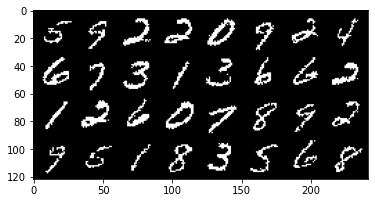

In [6]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

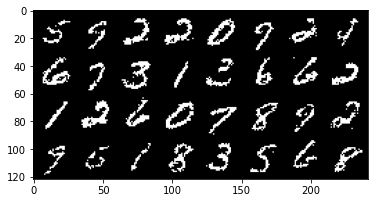

In [7]:
show_adn_save("geradas",make_grid(v1.view(32,1,28,28).data))

Como podemos ver, na imagem de cima temos as imagens reais de amostras do dataset MNIST, enquanto a imagem de baixo apresenta as amostras geradas pela RBM.